# 9.1 K-means Clustering
Old Faithful data from [here](http://research.microsoft.com/en-us/um/people/cmbishop/PRML/webdatasets/faithful.txt).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

## Load the data and standarize

In [3]:
data = np.loadtxt('../data/old_faithful/faithful.txt', dtype=str, delimiter=' ')

In [4]:
data = data.astype(np.float64)

In [5]:
data.shape

(272, 2)

In [6]:
N = data.shape[0]  # number of data points
D = data.shape[1]  # dimension of data
K = 2  # number of clusters

In [7]:
MEAN = np.mean(data, axis=0, keepdims=True)
SD = np.std(data, axis=0, keepdims=True) 

In [8]:
X = (data - MEAN) / SD  # standarized

In [9]:
np.mean(X, axis=0)  # confirm zero mean

array([4.48579082e-16, 4.27048103e-16])

In [10]:
np.std(X, axis=0)  # confirm unit variance

array([1., 1.])

In [11]:
# initial value as in the figure (deliverately chosen to be poor values)
mus = np.array([[1.4, -1], 
               [-1.4, 1]])
c = None  # no clusters assigned yet

In [12]:
def calculate_bisector(mus):
    """calculate the perpendicular bisector of the two cluster centers
    
    Args:
        mus (np.array, (2, 2), float): coordinates of cluster centers, mus[0] is the center of the first cluster 
    Returns:
        a (float): slope
        b (float): intercept 
    """
    a = - (mus[0, 0] - mus[1, 0]) / (mus[0, 1] - mus[1, 1])  # slope of the bisector is orthogonal to the line connecting the two centers
    mus_0 = mus.mean(axis=0)  # mean of the two centers
    b = mus_0[1] - a * mus_0[0]  # make sure the bisector goes through the mean of the centers
    return a, b

In [13]:
def plot_scatter(X, c, mus, plot_line=False):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.7))
    
    if c is None:  # no clusters assigned yet
        ax.scatter(X[:, 0], X[:, 1], facecolors='g', s=15, lw=1.5)
    else:
        ax.scatter(X[:, 0], X[:, 1], c=c, cmap=cmap, s=15, lw=1.5)
    
    if plot_line:
        a, b = calculate_bisector(mus)
        xx = np.linspace(-2.5, 2.5, 100)
        yy = a * xx + b
        ax.plot(xx, yy, 'm-')
    
    ax.scatter(mus[0, 0], mus[0, 1], marker='x', s=200, facecolor='w', lw=6)
    ax.scatter(mus[1, 0], mus[1, 1], marker='x', s=200, facecolor='w', lw=6)
    ax.scatter(mus[0, 0], mus[0, 1], marker='x', s=100, facecolor='r', lw=2)
    ax.scatter(mus[1, 0], mus[1, 1], marker='x', s=100, facecolor='b', lw=2)
    ax.set_xlim(-2.3, 2.3)
    ax.set_ylim(-2.3, 2.3)
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    plt.show()

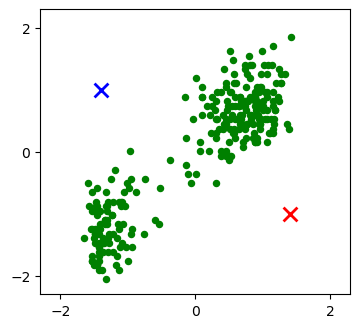

In [14]:
plot_scatter(X, c, mus)

## K-means algorithm

In [15]:
def E_step(X, mus):
    """E-step of the K-means algorithm

    Args:
        X (np.array, (N, D), float): data
        mus (np.array, (K, D), float): coordinates of cluster centers
    Returns:
        J_E (float): distortion measure after the E-step
        c (np.array, (N, ), int): array of cluster indices
        r (np.array, (N, K), float): one-hot encoding of cluster
    """
    S_xy = (X[:, None, :] - mus[None, :, :]) ** 2  # calculate the squared difference between each point and the centroids
    S = np.sum(S_xy, axis=-1)  # sum along x and y to get squared distance
    c = np.argmin(S, axis=-1)  # assign each point to the closest centroid (9.2)

    # convert cluster index to one-hot vector
    r = np.eye(K)[c]

    J_E = np.sum(r * S)  # (9.1)
    return J_E, c, r

In [16]:
def M_step(X, r):
    """M-step of the K-means algorithm

    Args:
        X (np.array, (N, D), float): data
        r (np.array, (N, K), float): one-hot encoding of cluster
    Returns:
        J_M (float): distortion measure after the M-step
        mus (np.array, (K, D), float): coordinates of the updated cluster centers
    """
    for k in range(K):
        mus[k] = (r[:, [k]] * X).sum(axis=0)  / r[:, k].sum()  # (9.4)

    S_xy = (X[:, None, :] - mus[None, :, :]) ** 2  # calculate the squared difference between each point and the centroids
    S = np.sum(S_xy, axis=-1)  # sum along x and y (will not take sqrt as it will not change the relative distance)
    J_M = np.sum(r * S)

    return J_M, mus

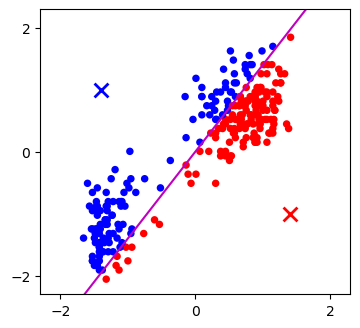

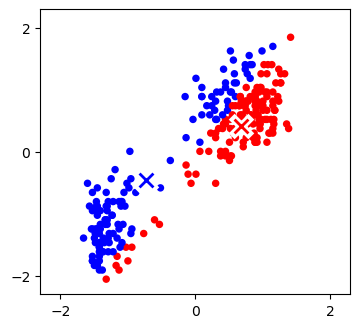

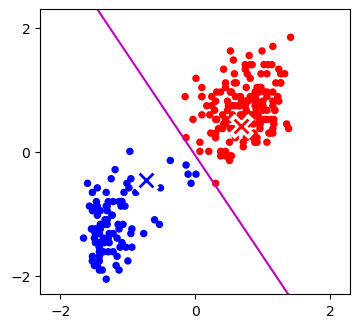

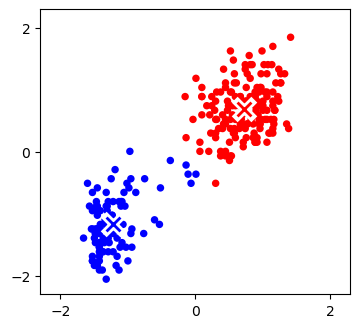

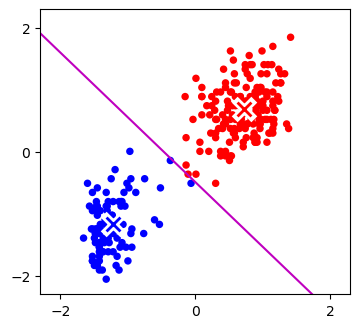

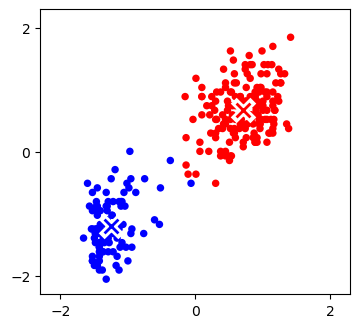

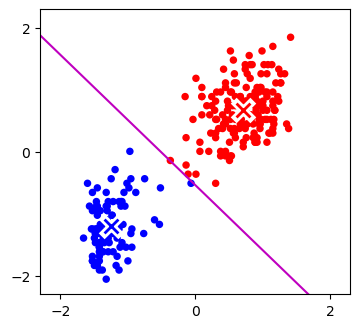

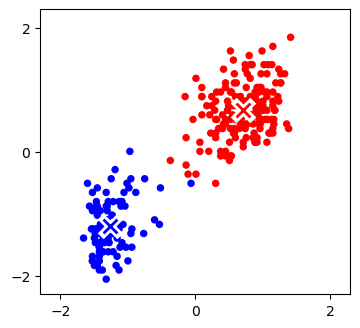

In [17]:
J_E_list = []
J_M_list = []

while True:
    J_E, c, r = E_step(X, mus)
    if len(J_M_list) > 0 and np.isclose(J_E, J_M_list[-1]):
        break
    plot_scatter(X, c, mus, plot_line=True)
    
    J_M, mus = M_step(X, r)
    plot_scatter(X, c, mus)

    J_E_list.append(J_E)
    J_M_list.append(J_M)

In [18]:
J = np.array([J_E_list, J_M_list])
J = J.ravel(order='F')

In [19]:
J

array([1048.39828343,  357.50099951,  170.87041318,   80.96792556,
         79.90691263,   79.63566082,   79.60581076,   79.57595949])

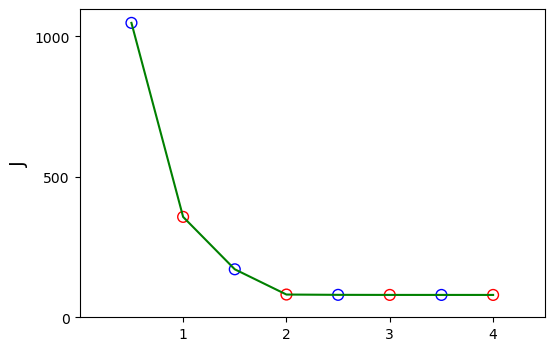

In [20]:
# Reproduce figure 9.2
plt.figure(figsize=(6, 4))
plt.scatter(np.arange(0.5, len(J_E_list), 1), J_E_list , s=60, edgecolor='b', facecolor='none')
plt.scatter(np.arange(1, len(J_M_list) + 1, 1), J_M_list, s=60, edgecolor='r', facecolor='none')
plt.plot(np.arange(0.5, len(J_M_list) + 0.5, 0.5), J, 'g-')
plt.xticks(np.arange(1, len(J_E_list) + 1, 1))
plt.yticks([0, 500, 1000])
plt.xlim(0, 4.5)
plt.ylabel('J', fontsize=14)
plt.show()